In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer


from textblob import TextBlob
from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [2]:
data = pd.read_csv("data/1600000.processed.noemoticon.csv", encoding='latin-1')
# o.decode('latin-1').encode("utf-8")

In [3]:
print(data)

       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_  \
0      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
1      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
2      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
3      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   
4      0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY         joy_wolf   
...   ..         ...                           ...       ...              ...   
19994  4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY  AmandaMarie1028   
19995  4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY      TheWDBoards   
19996  4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY           bpbabe   
19997  4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY     tinydiamondz   
19998  4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   RyanTrevMorris   

      @switchfoot http://tw

## Pre-process Data

In [188]:
new_data = data.iloc[:, [0,5]]

In [5]:
new_data.iloc[1,]

0                                                                                                                                                                      0
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D    @Kenichan I dived many times for the ball. Man...
Name: 1, dtype: object

In [108]:
def no_user_alpha(tweet):
    
    excluded_punct = [".", ",", ":", "^", ";", "-"]
    
    tweet_list = tweet.split()
    clean_tokens = [re.sub('@[\w]+','',t) for t in tweet_list if re.match(r'[^\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_url = re.sub(r'http\S+', '', clean_s)
    
    clean_punctuation = re.sub('(?<! )(?=[.,#!?()])|(?<=[.,#!?()])(?! )', ' ', clean_url)
    clean_mess = [word.lower() for word in clean_punctuation.split() if word.lower() not in stopwords.words('english') and word not in  excluded_punct]
    
    clean_apos = [item.replace("'", "") for item in clean_mess]
    
    return [item.replace("\"", "") for item in clean_apos]

cell = 0

print(new_data.iloc[cell, 1])
print("\n--------------\n")
print(no_user_alpha(new_data.iloc[cell, 1]))

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

--------------

['upset', 'cant', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah', '!']


In [7]:
def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

print(normalization(new_data.iloc[1,1].split()))

['@Kenichan', 'I', 'dive', 'many', 'time', 'for', 'the', 'ball.', 'Managed', 'to', 'save', '50%', 'The', 'rest', 'go', 'out', 'of', 'bound']


In [8]:
def delete_long_words(vocabulary):
    new_vocab = []
    for i in range(len(vocabulary)):
        if len(vocabulary[i]) <= 15:
            new_vocab.append(vocabulary[i])
            
    return new_vocab

In [9]:
def text_processing(tweet):
    return delete_long_words(normalization(no_user_alpha(tweet)))

print(text_processing(new_data.iloc[1, 1]))

['dive', 'many', 'time', 'ball', 'manage', 'save', 'rest', 'go', 'bound']


In [ ]:
pre_new_data = {'Sentiment':[], 'Sentence': []} 

for i in range(len(new_data)):
    pre_new_data['Sentiment'].append(new_data.iloc[i, 0])
    pre_new_data['Sentence'].append(get_bigrams(text_processing(new_data.iloc[i, 1])))

pre_new_data = pd.DataFrame(pre_new_data) 

In [ ]:
print(pre_new_data.iloc[:5,])

In [155]:
processed_sentence = new_data.iloc[:, 1].apply(text_processing).to_list()

vocabulary = [inner for outer in processed_sentence for inner in outer]

In [156]:
print(vocabulary[:10])

['upset', 'cant', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today']


In [17]:
freq_dist = FreqDist(vocabulary)
freq_dist.most_common(10)

[('!', 11017),
 ('?', 3036),
 ('get', 2226),
 ('go', 2037),
 ("i'm", 1632),
 ('work', 1410),
 ('good', 1228),
 ('day', 1174),
 ('today', 1001),
 ('like', 949)]

In [18]:
FreqDist(len(w) for w in vocabulary).most_common()

[(4, 41848),
 (5, 27276),
 (3, 22724),
 (1, 17582),
 (6, 16001),
 (7, 11119),
 (2, 6306),
 (8, 6255),
 (9, 3984),
 (10, 2215),
 (11, 1022),
 (12, 560),
 (13, 343),
 (14, 151),
 (15, 135)]

In [19]:
new_vocab = delete_long_words(vocabulary)
FreqDist(len(w) for w in new_vocab).most_common()

[(4, 41848),
 (5, 27276),
 (3, 22724),
 (1, 17582),
 (6, 16001),
 (7, 11119),
 (2, 6306),
 (8, 6255),
 (9, 3984),
 (10, 2215),
 (11, 1022),
 (12, 560),
 (13, 343),
 (14, 151),
 (15, 135)]

In [20]:
tokens = [inner for outer in processed_sentence for inner in outer]
def get_bigrams(tokens):
    return [(tokens[i],tokens[i+1]) for i in range(0,len(tokens)-1)]
 
bigrams_vocab = get_bigrams(tokens)

In [21]:
# how subjective or opinionated the text is; a score of 0 is fact, and a score of +1 is very much an opinion
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# how positive or negative the text is;
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity


sentences_info = {'Subjectivity':[], 'Polarity':[], 'Sentiment': []} 

concat_pro_words = new_data.iloc[:, 1].apply(text_processing).str.join(" ").to_list()

for i in range(len(concat_pro_words)):
    sentiment = getPolarity(concat_pro_words[i])
    sentences_info['Subjectivity'].append(getSubjectivity(concat_pro_words[i]))
    sentences_info['Polarity'].append(sentiment)
    
    if sentiment == 0:
        sentences_info['Sentiment'].append('Neutral')
    elif sentiment > 0:
        sentences_info['Sentiment'].append('Positive')
    else:
        sentences_info['Sentiment'].append('Negative')

    
sentences_info = pd.DataFrame(sentences_info) 


In [22]:
print(sentences_info.iloc[:5, ])

   Subjectivity  Polarity Sentiment
0           0.0     0.000   Neutral
1           0.5     0.500  Positive
2           0.4     0.200  Positive
3           1.0    -0.625  Negative
4           0.4     0.200  Positive


In [50]:
print(new_data.iloc[:, 0].value_counts())
print("\n-----------\n")
print(sentences_info.iloc[:, 2].value_counts())


4    10001
0     9998
Name: 0, dtype: int64

-----------

Neutral     9628
Positive    7251
Negative    3120
Name: Sentiment, dtype: int64


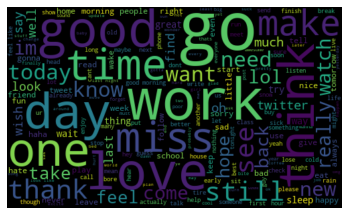

In [51]:
allWords = ' '.join([twts for twts in concat_pro_words])
wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=100).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

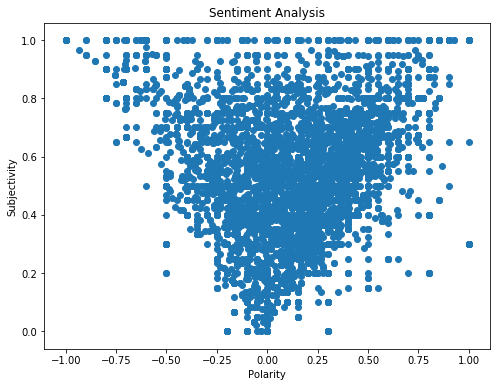

In [52]:
# Plotting 
plt.figure(figsize=(8,6)) 

plt.scatter(sentences_info["Polarity"] , sentences_info["Subjectivity"])   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [31]:
freq_dist = FreqDist(bigrams_vocab)
freq_dist.most_common(15)

[(('!', '!'), 3197),
 (('?', '?'), 525),
 (('good', 'morning'), 266),
 (('?', '!'), 199),
 (('last', 'night'), 197),
 (('!', "i'm"), 193),
 (('day', '!'), 144),
 (('!', 'thank'), 144),
 (('thank', '!'), 141),
 (('!', 'get'), 128),
 (('!', 'love'), 126),
 (('feel', 'like'), 125),
 (('!', 'good'), 122),
 (('today', '!'), 119),
 (('morning', '!'), 113)]

In [109]:
processed_sentence = new_data.iloc[:, 1].apply(text_processing).to_list()

vocabulary = [inner for outer in processed_sentence for inner in outer]

snot            3
distractions    3
scrub           3
soundtrack      3
riddle          3
               ..
tayg            1
cnet            1
mangalore       1
irregular       1
leawood         1
Length: 15000, dtype: int64
(15000,)


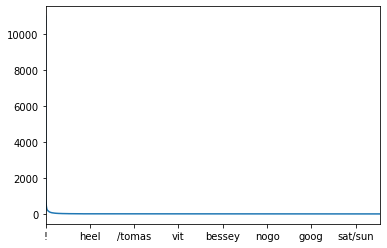

In [123]:
freq_d = pd.Series(vocabulary).value_counts()
print(freq_d[-15000:])
print(freq_d[-15000:].shape)
freq_d.plot(kind='line', ax=None, figsize=None, use_index=True,
            title=None, grid=None, legend=False, style=None,
            logx=False, logy=False, loglog=False, xticks=None,
            yticks=None, xlim=None, ylim=None, rot=None,
            fontsize=None, colormap=None, table=False, yerr=None,
            xerr=None, label=None, secondary_y=False)

In [135]:
print(new_data.iloc[:, 1])

0        is upset that can't update Facebook by texting...
1        @Kenichan I dived many times for ball. Managed...
2              whole body feels itchy and like its on fire
3        @nationwideclass no, it's not behaving at all....
4                                 @Kwesidei not whole crew
                               ...                        
19994    Just woke up. Having no school is best feeling...
19995    TheWDB.com Very cool hear old Walt interviews!...
19996         Are ready for MoJo Makeover? Ask for details
19997    Happy 38th Birthday boo of alll time!!! Tupac ...
19998    happy #charitytuesday @theNSPCC @SparksCharity...
Name: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, Length: 19999, dtype: object


In [166]:
processed_sentence = new_data.iloc[:, 1].apply(text_processing).to_list()

vocabulary = [inner for outer in processed_sentence for inner in outer]


In [164]:
print(pd.Series(' '.join(new_data.iloc[:, 1]).split()).value_counts()[-10:])

conditioner              1
Pookie                   1
headstart                1
HOLDING                  1
@shennyunho              1
wonderin                 1
Corbin,                  1
almst                    1
finish,                  1
http://blip.fm/~8bluq    1
dtype: int64


In [213]:
fdist=FreqDist(vocabulary)
rare_words = list(filter(lambda x: x[1]>=5,fdist.items()))

rare_words = [a_tuple[0] for a_tuple in rare_words]

In [ ]:
def generate_vocab(tweets):
    processed_sentence = tweets.iloc[:, 1].apply(text_processing).to_list()

    return [inner for outer in processed_sentence for inner in outer]

def get_rare_words(vocabulary):
    fdist=FreqDist(vocabulary)
    rare_words = list(filter(lambda x: x[1]>3,fdist.items()))

    return [a_tuple[0] for a_tuple in rare_words]

def remove_rare_words(tweets):
    rare_words = get_rare_words(generate_vocab(tweets))
    
    new_tweets = tweets.iloc[:, 1].apply(lambda x: [item for item in x.split() if item in rare_words])
    
    for i in range(len(tweets.iloc[:, 1])):
        tweets.iloc[i, 1] = " ".join(tweets.iloc[i, 1])
        
    return tweets

print(remove_rare_words(new_data))

/Users/jordisaleilles/.local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [242]:
new_data = data.iloc[:, [0,5]]

print(new_data.iloc[:10, 1])

#new_data.iloc[:, 1] = new_data.iloc[:, 1].apply(lambda x: [item for item in x.split() if item in rare_words])

0    is upset that he can't update his Facebook by ...
1    @Kenichan I dived many times for the ball. Man...
2      my whole body feels itchy and like its on fire 
3    @nationwideclass no, it's not behaving at all....
4                        @Kwesidei not the whole crew 
5                                          Need a hug 
6    @LOLTrish hey  long time no see! Yes.. Rains a...
7                 @Tatiana_K nope they didn't have it 
8                            @twittera que me muera ? 
9          spring break in plain city... it's snowing 
Name: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, dtype: object


In [229]:
for i in range(len(new_data.iloc[:, 1])):
    new_data.iloc[i, 1] = " ".join(new_data.iloc[i, 1])

In [236]:
print(new_data.iloc[:10, 1])

processed_sentence2 = new_data.iloc[:, 1].apply(text_processing).to_list()

vocabulary2 = [inner for outer in processed_sentence2 for inner in outer]

fdist2=FreqDist(vocabulary2)
rare_words2 = list(fdist2.items())

0    upset update might cry result today
1                      many save rest go
2             whole body itchy like fire
3                                    see
4                             whole crew
5                                    hug
6                   hey long time fine ?
7                              nope have
8                                  que ?
9                     spring break plain
Name: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, dtype: object


In [237]:
print(rare_words2)

[('upset', 29), ('update', 36), ('might', 119), ('cry', 38), ('result', 8), ('today', 471), ('many', 120), ('save', 17), ('rest', 61), ('go', 803), ('whole', 52), ('body', 29), ('itchy', 6), ('like', 834), ('fire', 10), ('see', 470), ('crew', 5), ('hug', 20), ('hey', 85), ('long', 160), ('time', 499), ('fine', 35), ('?', 85), ('nope', 8), ('que', 8), ('spring', 30), ('break', 57), ('plain', 5), ('ears', 7), ('bear', 10), ('watch', 147), ('loss', 15), ('idk', 10), ('never', 175), ('talk', 78), ('anymore', 33), ('really', 505), ('zac', 2), ('wish', 246), ('miss', 311), ('death', 11), ('scene', 8), ('hurt', 45), ('film', 18), ('cut', 32), ('file', 9), ('ahh', 10), ('ive', 30), ('always', 163), ('rent', 9), ('love', 588), ('table', 7), ('day', 799), ('get', 1048), ('much', 363), ('one', 556), ('friend', 82), ('meet', 63), ('*sigh*', 14), ('cake', 16), ('week', 167), ('class', 100), ('tomorrow', 181), ('hate', 202), ('call', 85), ('wake', 75), ('people', 219), ('sleep', 255), ('im', 386), (

In [235]:
print(pd.Series(' '.join(new_data.iloc[:, 1]).split()).value_counts())

have        1667
be          1377
get         1048
up           977
like         834
            ... 
impress        1
penn           1
mtv            1
affect         1
organize       1
Length: 2917, dtype: int64


In [238]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [239]:
msg_train, msg_test, label_train, label_test = train_test_split(new_data.iloc[:, 1], new_data.iloc[:, 0], test_size=0.2)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

# 0.74275

              precision    recall  f1-score   support

           0       0.62      0.69      0.65      1814
           4       0.72      0.64      0.68      2186

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000

[[1260  554]
 [ 784 1402]]
0.6655


In [358]:
unique, counts = np.unique(predictions, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 2114]
 [   4 1886]]


In [172]:
import tweepy

In [174]:
consumer_key = "Qs13neYllWbteSFCSMCBNPPUf"
consumer_secret = "PLgtHZmyKenCdN0UoUN8cdKjzs2VsvEIJv1jPfIHKXXVx6TNiO"

access_token = "1140023161980968961-gvTNlDyHEFpSXjmNKWLBdneYwsVzTK"
access_token_secret = "ENC73nuYB0HlGuNczFYG4VeLn0zAvLgWoVtA6AsTXCrhs"

In [175]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [391]:
api = tweepy.API(auth)

search_words = "#Biden"

public_tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en", 
              result_type='mixed').items(200)

tweets = {'Tweets': []}

for i in range(100):
    for tweet in public_tweets:
        if tweet.lang == "en":
            tweets['Tweets'].append(tweet.text)
        
tweets_df = pd.DataFrame(data=tweets)


0    Will someone please make it stop? \nWhen does ...
1    Playing defense, #Trump claims #Biden opposes ...
2    “We need prosecution of the coup cabal over th...
3    RT @GrrrGraphics: New #BenGarrison cartoon #El...
4    RT @ellymelly: Wouldn't it be easier if #Biden...
Name: Tweets, dtype: object


In [392]:

print(tweets_df.iloc[:5, 0])
print(tweets_df.shape)

0    Will someone please make it stop? \nWhen does ...
1    Playing defense, #Trump claims #Biden opposes ...
2    “We need prosecution of the coup cabal over th...
3    RT @GrrrGraphics: New #BenGarrison cartoon #El...
4    RT @ellymelly: Wouldn't it be easier if #Biden...
Name: Tweets, dtype: object
(200, 1)


In [393]:
print(text_processing(tweets_df.iloc[0,0]))
print(tweets_df.iloc[0,0])

['someone', 'please', 'make', 'stop', '?', 'become', 'elder', 'abuse', '?', 'would', 'sad', 'wasn’t', 'scary', 'that…']
Will someone please make it stop? 
When does this become elder abuse? 

It would be sad if it wasn’t so scary that… https://t.co/hrogoKngwM


In [394]:
delete_long_words(normalization(no_user_alpha(tweets_df.iloc[0,0])))


['someone',
 'please',
 'make',
 'stop',
 '?',
 'become',
 'elder',
 'abuse',
 '?',
 'would',
 'sad',
 'wasn’t',
 'scary',
 'that…']

In [395]:
tweets_predictions = pipeline.predict(tweets_df.iloc[:,0])


In [396]:
unique, counts = np.unique(tweets_predictions, return_counts=True)

pred_counts = np.asarray((unique, counts)).T

if pred_counts[0][0] == 4:
    percentage = (pred_counts[0][1] * 100 / len(tweets_predictions)).round(2)
else:
    percentage = (100 - (pred_counts[0][1] * 100 / len(tweets_predictions))).round(2)

if percentage <= 50:
    print("Percentage of Happiness :\n", percentage, "% :(")
else:
    print("Percentage of Happiness :\n", percentage, " % :)")
print("-------------\n")
print(np.asarray((unique, counts)).T)


Percentage of Happiness :
 71.5  % :)
-------------

[[  0  57]
 [  4 143]]


In [399]:
pipeline.predict(["Fuck Donald Trump"])

array([0])